## Introduction
Time series forecasting is a critical component of many real-world applications, from finance and stock market prediction to weather forecasting and demand forecasting in supply chain management. Accurate and reliable predictions of future values based on historical data can provide invaluable insights for decision-making and planning. In the realm of time series forecasting, the Quantum Long Short-Term Memory (QLSTM) neural network architecture has emerged as a powerful tool for handling sequential data.

The QLSTM is a variant of the widely used Long Short-Term Memory (LSTM) network, designed to capture both short-term and long-term dependencies in time series data. It combines the strengths of traditional LSTMs with certain enhancements, making it particularly well-suited for complex and chaotic time series datasets. This innovative architecture has shown promising results in a variety of domains, making it a go-to choice for data scientists and researchers aiming to harness the predictive potential of neural networks.

In this codebase, we present a comprehensive implementation of the QLSTM neural network for time series forecasting. This code is intended to serve as a versatile and user-friendly tool for practitioners and researchers looking to leverage QLSTMs for their forecasting tasks. Whether you are an experienced deep learning expert or just getting started with neural networks, this codebase will provide you with the necessary tools and resources to:

0.- Preprocess Time Series Data: Clean, format, and prepare your time series data for training and evaluation.

1.- Build the QLSTM Model: Create a robust QLSTM architecture tailored to your specific forecasting problem. You can customize hyperparameters, network layers, and activation functions to suit your needs.

2.- Train the Model: Utilize historical time series data to train the QLSTM network. The code supports various training options, including batch size, learning rate, and early stopping to ensure efficient convergence.

3.- Evaluate Model Performance: Assess the accuracy and effectiveness of the QLSTM model by measuring metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE).

4.- Generate Forecasts: Use the trained QLSTM model to make future predictions, allowing you to gain insights into future trends and patterns in your time series data.

5.- Visualize Results: Visualize the model's predictions alongside the actual time series data, enabling you to gain a deeper understanding of its forecasting capabilities.

By providing this QLSTM time series forecasting codebase, we aim to empower users to tackle a wide range of forecasting challenges effectively. Whether you are interested in predicting stock prices, energy consumption, or any other time-dependent phenomenon, the QLSTM codebase offers a powerful and flexible solution to enhance your forecasting endeavors. With the right data and the right model, you can unlock valuable insights and make informed decisions in your domain of interest.

In the following experiments we test this tool for common functions such as $f(t) = sin(t)$, $f(t) = 2t^3 + 5t^2 +8t -9 $ (polynomials), time series for economic indexes, etc.

We based this code in the paper Quantum Long Short-Term Memory: https://arxiv.org/pdf/2009.01783.pdf, Samuel Yen-Chi Chen, Shinjae Yoo, and Yao-Lung L. Fang.


In [1]:
pip install --force-reinstall pennylane==0.29.0

  Using cached PennyLane-0.29.0-py3-none-any.whl (1.3 MB)
  Using cached numpy-1.23.5-cp311-cp311-win_amd64.whl (14.6 MB)
  Obtaining dependency information for scipy from https://files.pythonhosted.org/packages/81/d7/d2537d51efb692d0c411e64267ba349e7668d40f5bc73cefe78ccd650dcd/scipy-1.11.3-cp311-cp311-win_amd64.whl.metadata
  Using cached scipy-1.11.3-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached networkx-3.1-py3-none-any.whl (2.1 MB)
  Obtaining dependency information for retworkx from https://files.pythonhosted.org/packages/96/e4/3fbaf64d7a891cff6bf0761546fedb0551b2a0efe132459984f85fcc4fa0/retworkx-0.13.1-py3-none-any.whl.metadata
  Using cached retworkx-0.13.1-py3-none-any.whl.metadata (10 kB)
  Obtaining dependency information for autograd from https://files.pythonhosted.org/packages/81/70/d5c7c2a458b8be96495c8b1634c2155beab58cbe864b7a9a5c06c2e52520/autograd-1.6.2-py3-none-any.whl.metadata
  Using cached autograd-1.6.2-py3-none-any.whl.metadata (706 bytes)
  Using cach

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: Could not install packages due to an OSError: [WinError 5] Acceso denegado: 'C:\\Users\\Usuario\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\~~mpy\\.libs\\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.



In [2]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


### Preprocess Time Series Data

In [3]:
import helper
import pennylane
import pandas as pd
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import torch

from torch import *
from torch import nn
from torch.utils.data import DataLoader
from IPython.display import Image


Read the data and remove the Date and Unnamed column from the csv.

In [4]:
df = pd.read_csv('dataset_stockPrices.csv')
df = df.drop(['Date' ,'Unnamed: 0'], axis=1)
df

,Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,...,GSK,LLY,NVS,NYSE,NASDAQ,FT3,FT6,FT9,ARIMA,Close_lead1
0,31.011450,14227229,30.050436,29.200291,29.514006,29.867322,0.353316,0.835852,30.871996,27.528586,...,20.441219,22.546120,26.214659,6671.140137,2017.979980,55.454947,50.337802,47.947327,31.011450,31.440840
1,31.440840,20081566,30.318975,29.299346,29.688906,30.115697,0.426791,0.963549,31.226444,27.372247,...,20.290920,22.639698,26.532934,6697.220215,2024.229980,55.359252,50.140845,47.659130,31.440840,31.183207
2,31.183207,10438080,30.564340,29.420211,29.822316,30.283528,0.461212,1.026446,31.473102,27.367319,...,20.280550,22.492653,26.608170,6687.939941,2024.430054,55.263482,49.944470,47.372320,31.183207,31.364504
3,31.364504,10302154,30.858779,29.556525,29.957940,30.452906,0.494965,1.086420,31.729366,27.383684,...,20.513784,22.800129,26.984316,6722.310059,2027.729980,55.167638,49.748691,47.086936,31.364504,30.839695
4,30.839695,12640452,30.973283,29.664667,30.034423,30.513340,0.478916,1.094567,31.853801,27.475534,...,20.285738,22.459227,26.857002,6709.040039,2028.770020,55.071723,49.553518,46.803017,30.839695,30.944656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2712,78.301529,13675457,75.931026,74.702836,75.305196,75.725497,0.420300,1.705192,78.113220,71.292452,...,38.856968,148.141144,82.393753,12302.190430,9682.910156,57.910147,55.622779,55.790021,76.887436,77.814888
2713,77.814888,9292930,76.515814,74.863687,75.491099,76.046941,0.555842,1.816324,78.496336,71.231038,...,38.423382,146.373550,81.836136,12286.980469,9615.809570,57.817099,55.415062,55.480641,78.191500,78.492363
2714,78.492363,10413347,77.157852,75.097238,75.713415,76.423160,0.709745,1.857931,78.813100,71.381377,...,38.469505,144.916718,82.576424,12641.440430,9814.080078,57.723926,55.207594,55.171523,77.972240,79.103050
2715,79.103050,9956838,77.684024,75.428935,75.964499,76.835451,0.870952,1.960788,79.350511,71.507360,...,39.087601,144.916718,82.364914,12836.599609,9924.750000,57.630627,55.000389,54.862711,78.309688,78.492363


We identify the dependent and independent variables:

In [5]:
target = "Close_lead1"

In [6]:
features = list(df.columns.difference(["Close", 'Close_lead1']))
features

['12ema',
 '20sd',
 '26ema',
 'AMGN',
 'ARIMA',
 'BMY',
 'FT3',
 'FT6',
 'FT9',
 'GSK',
 'JNJ',
 'LLY',
 'MACD',
 'NASDAQ',
 'NVS',
 'NYSE',
 'PFE',
 'SNP',
 'SNY',
 'VTRS',
 'VZ',
 'Volume',
 'ema',
 'log_momentum',
 'lower_band',
 'ma21',
 'ma7',
 'momentum',
 'neg',
 'neu',
 'pos',
 'upper_band']

### Data Processing

To preprocess the data, we initiate the procedure by partitioning it into training and testing datasets. Specifically, we allocate two-thirds of the data for the training set, while reserving the remaining one-third for the testing set.

In [7]:
training_percentage = 0.67
size = int(len(df) * training_percentage)

df_train = df.loc[:size].copy()
df_test = df.loc[size:].copy()

Subsequently, to mitigate the potential dominance of certain values within the features due to their magnitude, we *standardize* the data.

In [8]:
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

In [9]:
from utils import SequenceDataset

Lastly, the final stage in data processing, essential for LSTM preparation, involves organizing the data into a sequence of historical observations. For LSTM to effectively operate on time series data, it relies on utilizing a specific number of past observations to make future predictions. In our scenario, the sequence length determines the extent of historical context considered by the LSTM in forecasting. Having $n$ data, the LSTM can predict the next step ($n+1$) time series data. 

In [10]:
torch.manual_seed(101) #Sets the seed for generating random numbers.

batch_size = 1
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 3, 32])
Target shape: torch.Size([1])


### Training classical LSTM

We define the following training methods:

train_model: This function is designed for model training using data batches.
test_model: This function is tailored for evaluating the model's performance on the testing data.

We display the loss metric as a diagnostic tool to measure the model's performance in relation to the provided data.

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    accuracy = 1.0 / (avg_loss + 1e-7)

    print(f"Train loss: {avg_loss}")
    print(f"Train accuracy: {accuracy}")
    return avg_loss, accuracy


def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    accuracy = 1.0 / (avg_loss + 1e-7)
    print(f"Test loss: {avg_loss}")
    print(f"Test accuracy: {accuracy}")
    return avg_loss, accuracy

### Running the Classical LSTM

To gain insight into our QLSTM implementation, we'll start by elucidating our LSTM implementation. The LSTM architecture adheres to the following structure:
</br>
<img src="lstm2.jpg" alt="drawing" width="400"/>
Quantum Long Short-Term Memory, https://arxiv.org/pdf/2009.01783.pdf (Samuel Yen-Chi Chen, Shinjae Yoo, and Yao-Lung L. Fang (2020))

In straightforward terms, an LSTM employs a structure composed of four distinct neural network layers within each LSTM cell. These layers are as follows:

1.- Forget Layer </br>
2.- Input Layer </br>
3.- Update Layer </br>
4.- Output Layer </br>

You can observe these corresponding layers within the "W" cells illustrated in the diagram above. While we won't delve into the intricate technicalities here, it's crucial to recognize that these four layers constitute the fundamental components of an LSTM neural network model. These layers typically resemble conventional neural network layers, such as linear layers with rectified linear unit (ReLU) activations or convolutional layers.

In the upcoming code section, we ilutrate the training of an LSTM model with the objective of forecasting future stock prices. Subsequently, we assess its performance on the test dataset. The selection of a learning rate of 0.0001 has been a product of careful experimentation, where we identified the learning rate that consistently delivered precise results. In terms of training, we opt for a total of 20 epochs, a number we deemed adequate for achieving convergence and fulfilling the goals outlined in this notebook. Following training, we proceed to visualize three distinct graphs:

* A comparison plot that illustrates the model's predictions against actual stock prices.
* A graphical representation depicting the progression of test loss and training loss across epochs.

In [12]:
from utils import ShallowRegressionLSTM

In [13]:
learning_rate = 0.0001
num_hidden_units = 16

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
classical_loss_train = []
classical_acc_train = []
classical_loss_test = []
classical_acc_test = []
print("Untrained test\n--------")
test_loss, test_accuracy = test_model(test_loader, model, loss_function)
print()
classical_loss_test.append(test_loss)
classical_acc_test.append(test_accuracy)

for ix_epoch in range(0,21):
  print(f"Epoch {ix_epoch}\n---------")
  train_loss, train_accuracy = train_model(train_loader, model, loss_function, optimizer=optimizer)
  test_loss, test_accuracy = test_model(test_loader, model, loss_function)
  classical_loss_train.append(train_loss)
  classical_acc_train.append(train_accuracy)
  classical_loss_test.append(test_loss)
  classical_acc_test.append(test_accuracy)


Untrained test
--------
Test loss: 8.610089974459198
Test accuracy: 0.11614280354236715

Epoch 0.0
---------


C:\Users\Usuario\AppData\Local\Temp\ipykernel_13104\698315404.py:11: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  for ix_epoch in range(0,21):


Train loss: 0.2653262448187357
Train accuracy: 3.7689434898866714
Test loss: 2.6338869232546402
Test accuracy: 0.37966700590077723
Epoch 1.0
---------
Train loss: 0.03469269318470698
Train accuracy: 28.82443032695368
Test loss: 2.0061179035710284
Test accuracy: 0.4984751635845604
Epoch 2.0
---------
Train loss: 0.017827948982110514
Train accuracy: 56.091387285476166
Test loss: 1.7888868542208582
Test accuracy: 0.5590068157412135
Epoch 3.0
---------
Train loss: 0.011995089572995091
Train accuracy: 83.36675247311736
Test loss: 1.6140610899531145
Test accuracy: 0.619555197922235
Epoch 4.0
---------
Train loss: 0.009455384600385065
Train accuracy: 105.75872546598787
Test loss: 1.5142773796596458
Test accuracy: 0.6603809496161585
Epoch 5.0
---------
Train loss: 0.008296079437547552
Train accuracy: 120.53741213384505
Test loss: 1.4813240757145605
Test accuracy: 0.675071680051141
Epoch 6.0
---------
Train loss: 0.007585738907560235
Train accuracy: 131.82457631724492
Test loss: 1.4178956959720

Subsequently, we utilize the trained model to make predictions on the test dataset, followed by a thorough comparison of the predicted values with the actual ground truth values.

In [15]:
def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output

In [16]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

      Close_lead1  Model forecast
0       31.440840       30.782759
1       31.183207       30.853790
2       31.364504       31.018036
3       30.839695       31.142879
4       30.944656       30.962923
...           ...             ...
2712    77.814888       62.619530
2713    78.492363       62.696144
2714    79.103050       62.831009
2715    78.492363       62.947685
2716    78.024811       62.893097

[2718 rows x 2 columns]


C:\Users\Usuario\AppData\Local\Temp\ipykernel_13104\875173430.py:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(0,2717), df_out["Close_lead1"], label = "Real")
C:\Users\Usuario\AppData\Local\Temp\ipykernel_13104\875173430.py:3: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(0,2717), df_out["Model forecast"], label = "LSTM Prediction")


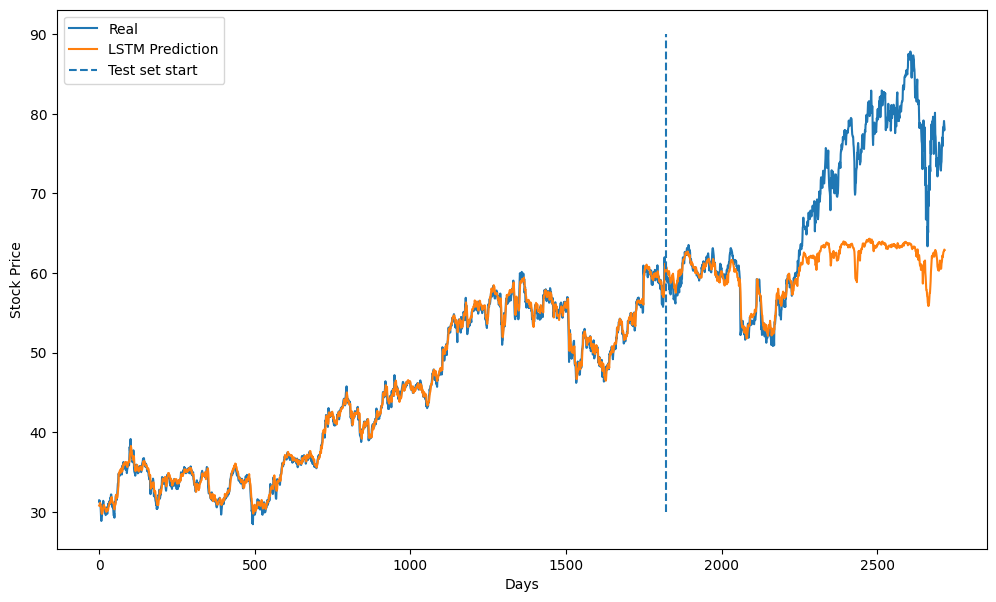

In [17]:
plt.figure(figsize=(12, 7))
plt.plot(range(0,2717), df_out["Close_lead1"], label = "Real")
plt.plot(range(0,2717), df_out["Model forecast"], label = "LSTM Prediction")
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.vlines(size, ymin = 30, ymax = 90, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_13104\4052620242.py:29: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.bar(range(1, len(inverse_differences)), absolute_differences, color='b', alpha=0.5, label='Inverse of Absolute Difference')


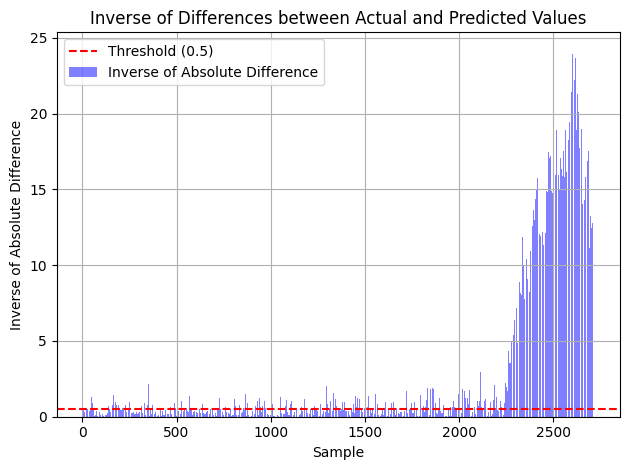

Accuracy: 48.64%


In [18]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_accuracy(y_true, y_pred, threshold=0.1):
    """
    Calculates accuracy based on a specific threshold.

    Args:
    - y_true (numpy array): The actual time series.
    - y_pred (numpy array): The predicted time series.
    - threshold (float): The threshold to determine if a prediction is correct.

    Returns:
    - float: The accuracy value.
    """
    # Calculate the absolute differences between the actual and predicted values
    absolute_differences = np.abs(y_true - y_pred)

    # Calculate the inverse of the absolute differences
    inverse_differences = 1.0 / (absolute_differences + 1e-10)  # Added a small epsilon to avoid division by zero

    # Calculate a boolean mask for correct predictions
    correct_predictions = absolute_differences < threshold
    
    # Calculate the accuracy
    accuracy = np.mean(correct_predictions)
    
    # Plot the accuracies over time
    plt.bar(range(1, len(inverse_differences)), absolute_differences, color='b', alpha=0.5, label='Inverse of Absolute Difference')
    plt.axhline(threshold, color='r', linestyle='--', label=f'Threshold ({threshold})')
    plt.xlabel('Sample')
    plt.ylabel('Inverse of Absolute Difference')
    plt.title('Inverse of Differences between Actual and Predicted Values')
    plt.legend()
    plt.grid(True)  # Add a grid
    plt.tight_layout()  # Automatically adjust the layout
    plt.show()
    
    return accuracy

# Example of usage
accuracy = calculate_accuracy(df_out["Close_lead1"].to_numpy(), df_out["Model forecast"].to_numpy(), threshold=0.5)
print(f"Accuracy: {accuracy * 100:.2f}%")



C:\Users\Usuario\AppData\Local\Temp\ipykernel_13104\2131256969.py:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(0, 22), classical_loss_test)


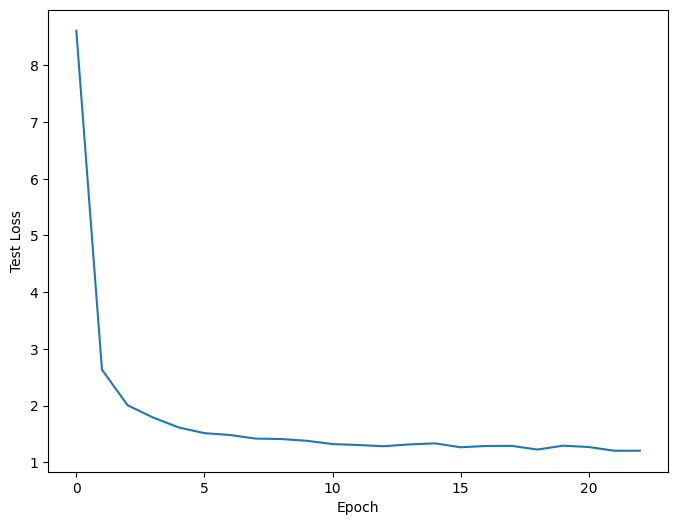

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(range(0, 22), classical_loss_test)
plt.ylabel('Test Loss')
plt.xlabel('Epoch')
plt.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_13104\1022959043.py:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(0, 22), classical_acc_test)


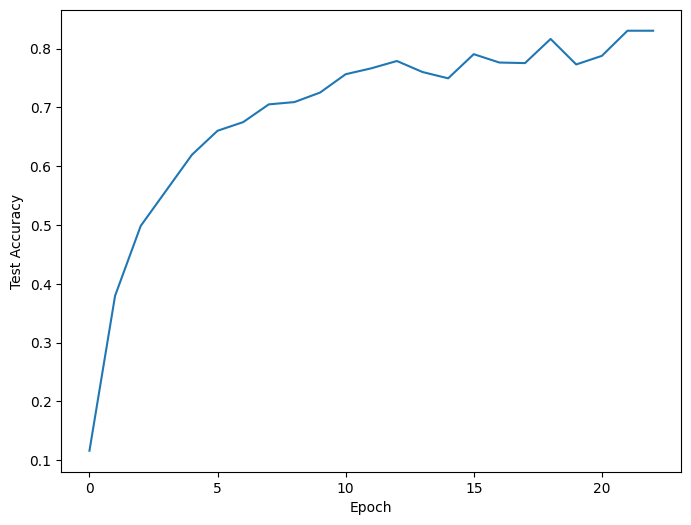

In [20]:
plt.figure(figsize=(8, 6))
plt.plot(range(0, 22), classical_acc_test)
plt.ylabel('Test Accuracy')
plt.xlabel('Epoch')
plt.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_13104\1382818532.py:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(0, 21), classical_loss_train)


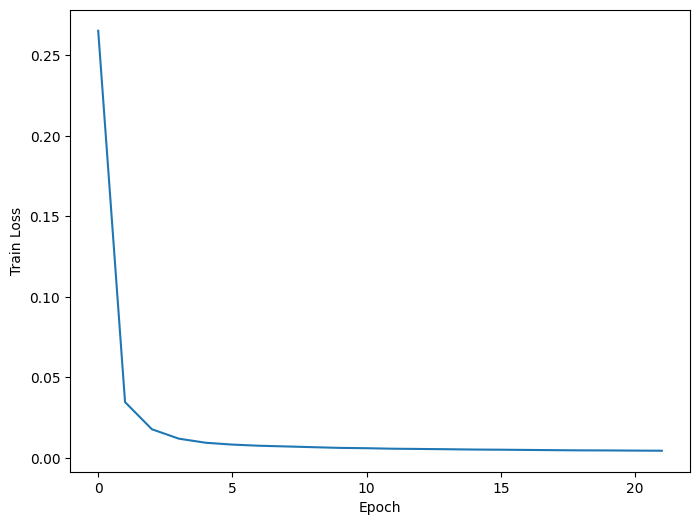

In [21]:
plt.figure(figsize=(8, 6))
plt.plot(range(0, 21), classical_loss_train)
plt.ylabel('Train Loss')
plt.xlabel('Epoch')
plt.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_13104\1298239571.py:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(0, 21), classical_acc_train)


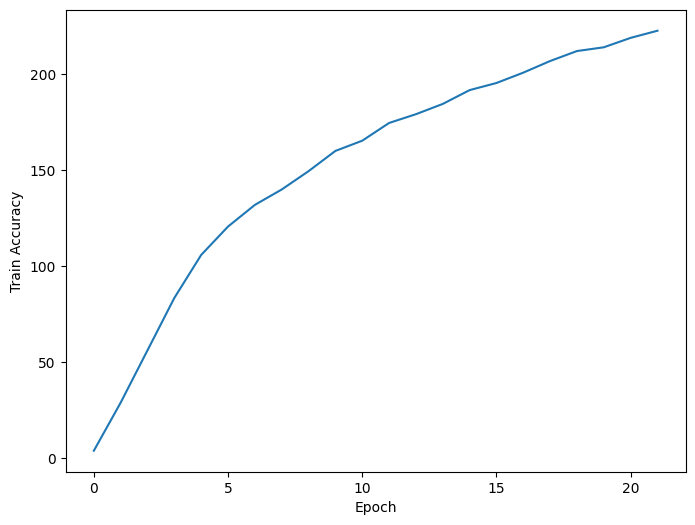

In [22]:
plt.figure(figsize=(8, 6))
plt.plot(range(0, 21), classical_acc_train)
plt.ylabel('Train Accuracy')
plt.xlabel('Epoch')
plt.show()

### Running the Quantum-LSTM

To implement QLSTM, we then replace the 4 key layers of the LSTM with variational quantum layers enabled by Pennylane. The variational quantum layers are based on the following variational quantum circuits.
<br/>
<br/>
QLSTM model: <br/>
<img src="QLSTM.PNG" alt="drawing" width="600"/>
<br/>
VQC: <br/>
<img src="vqc.jpg" alt="drawing" width="600"/>

Quantum Long Short-Term Memory, https://arxiv.org/pdf/2009.01783.pdf. By Samuel Yen-Chi Chen, Shinjae Yoo, and Yao-Lung L. Fang

As a consequence, the parameters subject to training are now the rotational parameters embedded within the quantum circuits, thereby giving rise to a hybrid quantum-classical neural network layer (with the optimizer being classical in nature). In the QLSTM research paper, the authors demonstrate that QLSTM exhibits superior trainability by "acquiring significantly more information than LSTM right from the outset of the first training epoch, and its loss diminishes more consistently and rapidly than that of its classical counterpart". Consequently, the aim of this study is to substantiate that QLSTM possesses the potential to surpass its classical counterpart in terms of accuracy and the rate at which it learns with each epoch.

While we have repurposed and made certain modifications to adapt it to our specific requirements, such as aligning it with the variational quantum circuits depicted above, we have also harnessed the built-in Pennylane simulator to execute these variational quantum circuits.

In the subsequent code section, our objective is to train a QLSTM model designed to forecast MRK stock prices. This exercise serves as a proof of concept, demonstrating that QLSTM not only holds potential for stock price prediction but also offers advantages over its classical counterpart. Our chosen configuration consists of 4 qubits, a single variational layer, and a learning rate of 0.05. The decision to employ 4 qubits was motivated by our desire to showcase its feasibility even with a limited number of qubits, while the latter two parameters were determined through experimentation over a few epochs to ascertain which settings yielded the most favorable results. Following training, we proceed to visualize three distinct graphs akin to those presented in the classical example.

In [23]:
from utils import QShallowRegressionLSTM

In [24]:
learning_rate = 0.05
num_hidden_units = 16

Qmodel = QShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units, n_qubits=4)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adagrad(Qmodel.parameters(), lr=learning_rate)

weight_shapes = (n_qlayers, n_vrotations, n_qubits) = (1, 3, 4)


In [25]:
quantum_loss_train = []
quantum_acc_train = []
quantum_loss_test = []
quantum_acc_test = []
print("Untrained test\n--------")
start = time.time()
test_loss, test_accuracy = test_model(test_loader, Qmodel, loss_function)
end = time.time()
print("Execution time", end - start)
quantum_loss_test.append(test_loss)

for ix_epoch in range(0, 20):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_loss, train_accuracy = train_model(train_loader, Qmodel, loss_function, optimizer=optimizer)
    test_loss, test_accuracy = test_model(test_loader, Qmodel, loss_function)
    end = time.time()
    print("Execution time", end - start)
    quantum_loss_train.append(train_loss)
    quantum_acc_train.append(train_accuracy)
    quantum_loss_test.append(test_loss)
    quantum_acc_test.append(test_accuracy)

Untrained test
--------
Test loss: 7.388531392035277
Test accuracy: 0.13534489242929865
Execution time 144.02132654190063
Epoch 0.0
---------


C:\Users\Usuario\AppData\Local\Temp\ipykernel_13104\3730670468.py:12: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  for ix_epoch in range(0, 20):


Train loss: 0.0387362314622459
Train accuracy: 25.81555770129247
Test loss: 1.5048266751753567
Test accuracy: 0.6645283141532822
Execution time 630.8577337265015
Epoch 1.0
---------
Train loss: 0.006378392343137824
Train accuracy: 156.77685982892658
Test loss: 1.4779272792019837
Test accuracy: 0.6766232320156057
Execution time 627.6195259094238
Epoch 2.0
---------
Train loss: 0.005503449533419149
Train accuracy: 181.70091754924889
Test loss: 1.3762717295602096
Test accuracy: 0.7266006456875252
Execution time 643.411169052124
Epoch 3.0
---------
Train loss: 0.005043149174294942
Train accuracy: 198.28486863130303
Test loss: 1.2830759615255989
Test accuracy: 0.7793770221314731
Execution time 647.4118654727936
Epoch 4.0
---------
Train loss: 0.0048400097161892894
Train accuracy: 206.60688675200507
Test loss: 1.2638918142436817
Test accuracy: 0.7912068973068827
Execution time 626.1193895339966
Epoch 5.0
---------
Train loss: 0.004611037157530292
Train accuracy: 216.8662448842871
Test loss: 

In [26]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col_Q = "Model forecast"
df_train[ystar_col_Q] = predict(train_eval_loader, Qmodel).numpy()
df_test[ystar_col_Q] = predict(test_loader, Qmodel).numpy()

df_out_Q = pd.concat((df_train, df_test))[[target, ystar_col_Q]]

for c in df_out_Q.columns:
    df_out_Q[c] = df_out_Q[c] * target_stdev + target_mean

print(df_out_Q)

      Close_lead1  Model forecast
0       31.440840       31.074741
1       31.183207       31.434050
2       31.364504       31.328800
3       30.839695       31.500854
4       30.944656       31.154125
...           ...             ...
2712    77.814888       63.366798
2713    78.492363       63.314106
2714    79.103050       63.397198
2715    78.492363       63.328255
2716    78.024811       63.372509

[2718 rows x 2 columns]


C:\Users\Usuario\AppData\Local\Temp\ipykernel_13104\2879606887.py:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(0,2717), df_out_Q["Close_lead1"], label = "Real")
C:\Users\Usuario\AppData\Local\Temp\ipykernel_13104\2879606887.py:3: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(0,2717), df_out_Q["Model forecast"], label = "QLSTM Prediction")


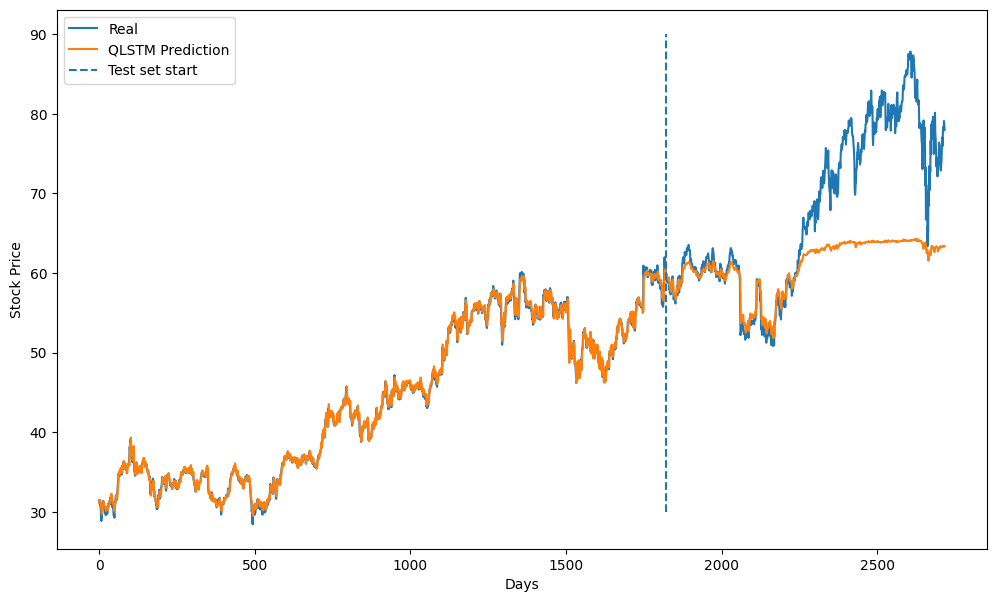

In [27]:
plt.figure(figsize=(12, 7))
plt.plot(range(0,2717), df_out_Q["Close_lead1"], label = "Real")
plt.plot(range(0,2717), df_out_Q["Model forecast"], label = "QLSTM Prediction")
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.vlines(size, ymin = 30, ymax = 90, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_13104\4052620242.py:29: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.bar(range(1, len(inverse_differences)), absolute_differences, color='b', alpha=0.5, label='Inverse of Absolute Difference')


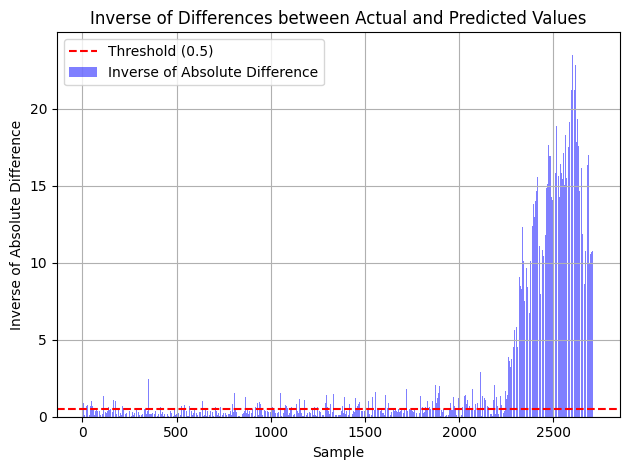

Accuracy: 54.12%


In [28]:
# Example of usage for Quantum LSTM
accuracy = calculate_accuracy(df_out_Q["Close_lead1"].to_numpy(), df_out_Q["Model forecast"].to_numpy(), threshold=0.5)
print(f"Accuracy: {accuracy * 100:.2f}%")

C:\Users\Usuario\AppData\Local\Temp\ipykernel_13104\2562507615.py:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(0,21), quantum_loss_test)


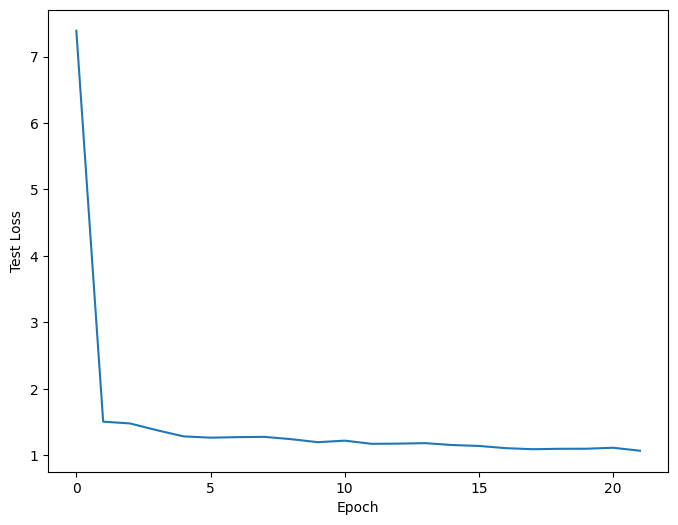

In [29]:
plt.figure(figsize=(8, 6))
plt.plot(range(0,21), quantum_loss_test)
plt.ylabel('Test Loss')
plt.xlabel('Epoch')
plt.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_13104\360302649.py:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(1,21), quantum_acc_test)


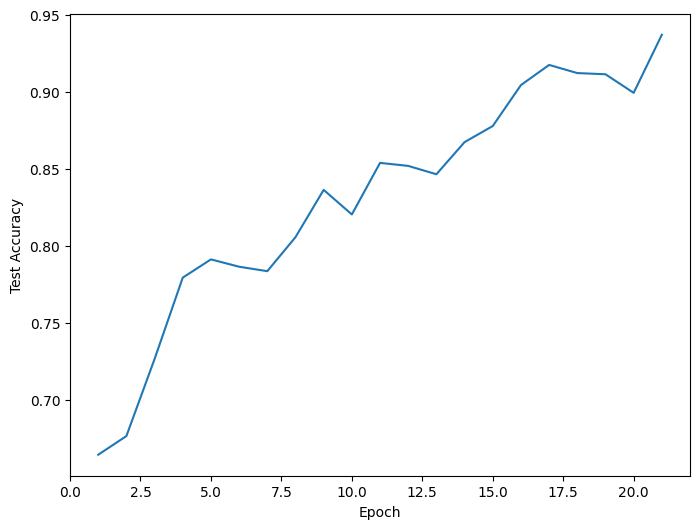

In [30]:
plt.figure(figsize=(8, 6))
plt.plot(range(1,21), quantum_acc_test)
plt.ylabel('Test Accuracy')
plt.xlabel('Epoch')
plt.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_13104\3741654444.py:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(0, 20), quantum_loss_train)


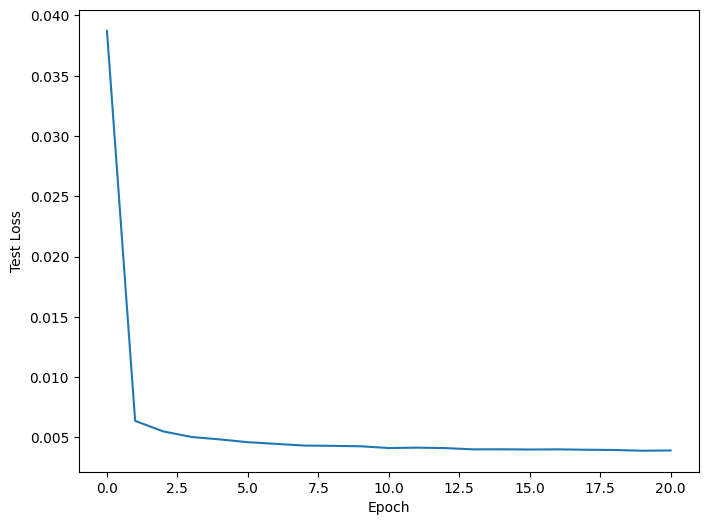

In [31]:
plt.figure(figsize=(8, 6))
plt.plot(range(0, 20), quantum_loss_train)
plt.ylabel('Train Loss')
plt.xlabel('Epoch')
plt.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_13104\3141963257.py:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(0, 20), quantum_acc_train)


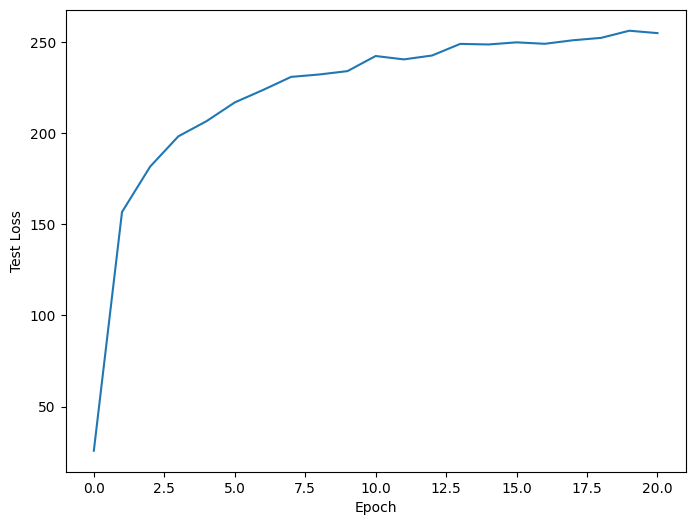

In [32]:
plt.figure(figsize=(8, 6))
plt.plot(range(0, 20), quantum_acc_train)
plt.ylabel('Train Accuracy')
plt.xlabel('Epoch')
plt.show()

### Comparison between Classical LSTM and QLSTM

Having successfully trained both models and gained initial insights into their performance, our next step involves conducting a comprehensive comparative analysis to gauge their relative effectiveness. This entails a systematic evaluation through the following lenses:

* Comparison of Model Predictions: We juxtapose the predictions generated by both models to discern their respective forecasting capabilities.

* Comparison of Loss Per Epoch: We assess the loss metrics for both training and testing datasets across epochs, providing a nuanced understanding of how the models adapt and generalize.

* Complexity Analysis and Parameter Comparison: We delve into a complexity analysis, scrutinizing factors such as the number of parameters in each model. This scrutiny allows us to quantify and compare the inherent intricacies of the models.

### Comparison of predictions

C:\Users\Usuario\AppData\Local\Temp\ipykernel_13104\4195470036.py:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(0, 2717), df_out["Close_lead1"], label = "Real")
C:\Users\Usuario\AppData\Local\Temp\ipykernel_13104\4195470036.py:3: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(0, 2717), df_out["Model forecast"], label = "LSTM")
C:\Users\Usuario\AppData\Local\Temp\ipykernel_13104\4195470036.py:4: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(0, 2717)

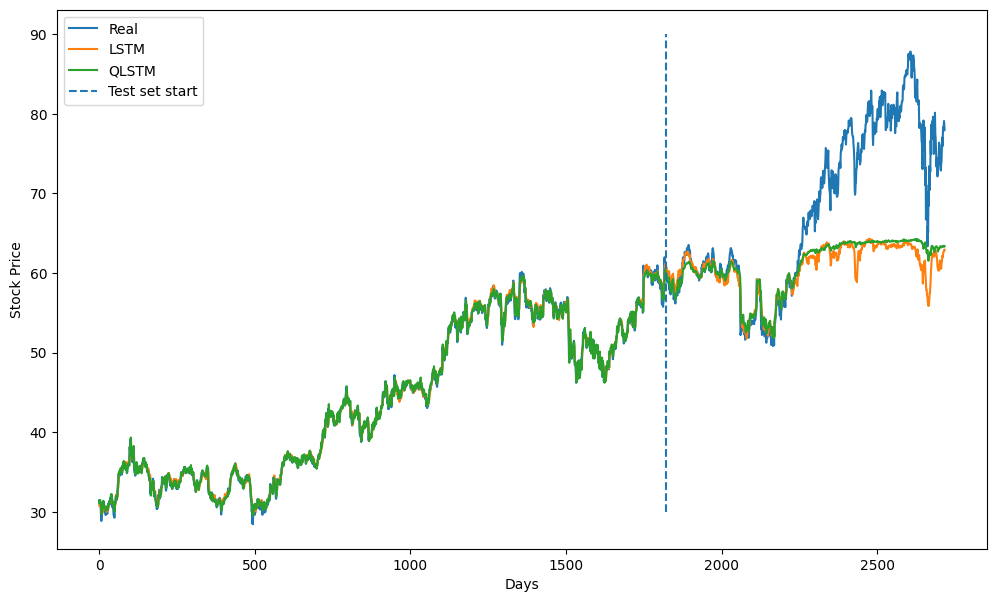

In [33]:
plt.figure(figsize=(12, 7))
plt.plot(range(0, 2717), df_out["Close_lead1"], label = "Real")
plt.plot(range(0, 2717), df_out["Model forecast"], label = "LSTM")
plt.plot(range(0, 2717), df_out_Q["Model forecast"], label = "QLSTM")
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.vlines(size, ymin = 30, ymax = 90, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()

As we can see from the graph, it's apparent that both the LSTM and QLSTM models yield similar outcomes. Both models demonstrate exceptional performance in forecasting the training dataset, and during the initial phases of the test dataset, they exhibit remarkable accuracy, closely aligning with the actual values. Moreover, even as they gradually deviate from the ground truth, both models manage to retain some level of fidelity, capturing certain nuances in the data's variation.

### Comparison of evolution of loss values

Now, we want to compare the evolution of the loss values by epoch. So, we compare the evolution of the train loss.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_13104\1501307920.py:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(0, 21), classical_loss_train, label = "LSTM")
C:\Users\Usuario\AppData\Local\Temp\ipykernel_13104\1501307920.py:3: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(0, 20), quantum_loss_train, label = "QLSTM")


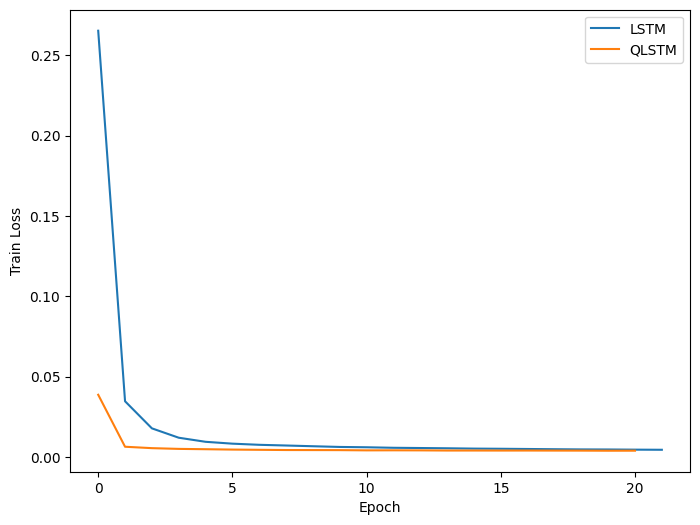

In [34]:
plt.figure(figsize=(8, 6))
plt.plot(range(0, 21), classical_loss_train, label = "LSTM")
plt.plot(range(0, 20), quantum_loss_train, label = "QLSTM")
plt.ylabel('Train Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

It's noteworthy that QLSTM rapidly accumulates a wealth of information within the initial epochs, surpassing the rate of learning exhibited by LSTM. Additionally, the results converge at a swifter pace in contrast to its classical counterpart, although both models ultimately converge to an adequately low loss value. This observation underscores QLSTM's enhanced trainability and its ability to glean insights more efficiently during the early training phases.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_13104\1281964968.py:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(0, 21), classical_loss_train, label = "LSTM")
C:\Users\Usuario\AppData\Local\Temp\ipykernel_13104\1281964968.py:3: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(0, 20), quantum_loss_train, label = "QLSTM")


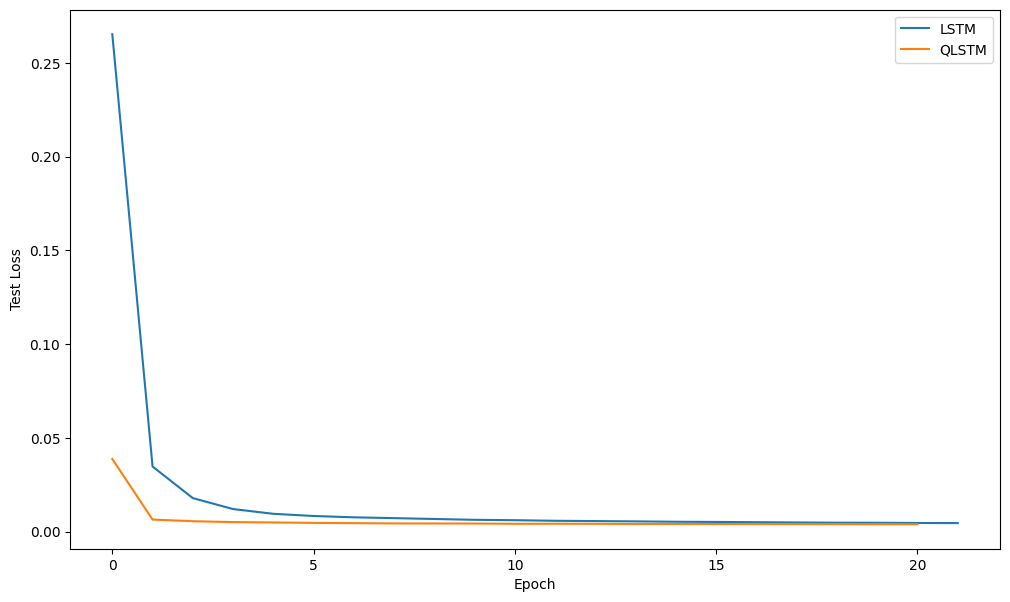

In [35]:
plt.figure(figsize=(12, 7))
plt.plot(range(0, 21), classical_loss_test, label = "LSTM")
plt.plot(range(0, 20), quantum_loss_test, label = "QLSTM")
plt.ylabel('Train Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Likewise, when examining the test loss, we observe a consistent pattern. QLSTM outpaces LSTM in assimilating a greater amount of information during the initial epochs and achieves convergence to a lower loss value at a notably accelerated rate. Impressively, QLSTM ultimately reaches an even lower test loss than LSTM, reaffirming its superior trainability. However, it's worth noting that while the loss metrics showcase this distinction, the predictions generated by both models remain reasonably comparable, highlighting the robustness of both approaches.

### Other time series forecasting using QLSTM

#### Sinusoidal function

In the following code we import data from the $f(t) = sin(t)$ function and tran the QLSTM model for predict the sine behaviour. 

In [1]:
import helper
import pennylane
import pandas as pd
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import torch

from torch import *
from torch import nn
from torch.utils.data import DataLoader
from IPython.display import Image

df = pd.read_csv('sin_data.csv')
df

,x,sin(x),sin(x)+1
0,0.0,0.000000,1.000000
1,0.1,0.099833,1.099833
2,0.2,0.198669,1.198669
3,0.3,0.295520,1.295520
4,0.4,0.389418,1.389418
...,...,...,...
1003,31.0,-0.404038,0.595962
1004,31.1,-0.310697,0.689303
1005,31.2,-0.214253,0.785747
1006,31.3,-0.115667,0.884333


In [37]:
target = "sin(x)+1"

In [38]:
features = list(df.columns.difference(['sin(x)+1']))
features

['sin(x)', 'x']

In [39]:
training_percentage = 0.67
size = int(len(df) * training_percentage)

df_train = df.loc[:size].copy()
df_test = df.loc[size:].copy()

In [40]:
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

## Classic prediction 

In [41]:
from utils import SequenceDataset

In [42]:
torch.manual_seed(101) #Sets the seed for generating random numbers.

batch_size = 1
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 3, 2])
Target shape: torch.Size([1])


In [43]:
import matplotlib.pyplot as plt
import numpy as np

def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    accuracy = 1.0 / (avg_loss + 1e-7)

    print(f"Train loss: {avg_loss}")
    print(f"Train accuracy: {accuracy}")
    return avg_loss, accuracy


def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    accuracy = 1.0 / (avg_loss + 1e-7)
    print(f"Test loss: {avg_loss}")
    print(f"Test accuracy: {accuracy}")
    return avg_loss, accuracy

In [44]:
from utils import ShallowRegressionLSTM

In [45]:
learning_rate = 0.0001
num_hidden_units = 16

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [46]:
classical_loss_train = []
classical_acc_train = []
classical_loss_test = []
classical_acc_test = []
print("Untrained test\n--------")
test_loss, test_accuracy = test_model(test_loader, model, loss_function)
print()
classical_loss_test.append(test_loss)
classical_acc_test.append(test_accuracy)

for ix_epoch in range(0,50):
  print(f"Epoch {ix_epoch}\n---------")
  train_loss, train_accuracy = train_model(train_loader, model, loss_function, optimizer=optimizer)
  test_loss, test_accuracy = test_model(test_loader, model, loss_function)
  classical_loss_train.append(train_loss)
  classical_acc_train.append(train_accuracy)
  classical_loss_test.append(test_loss)
  classical_acc_test.append(test_accuracy)

Untrained test
--------
Test loss: 0.996570614326618
Test accuracy: 1.0034410861407856

Epoch 0.0
---------


C:\Users\Usuario\AppData\Local\Temp\ipykernel_13104\1940319938.py:11: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  for ix_epoch in range(0,50):


Train loss: 0.8907605810982584
Train accuracy: 1.1226359910352752
Test loss: 0.7617861414747296
Test accuracy: 1.312704201724773
Epoch 1.0
---------
Train loss: 0.6044983942257652
Train accuracy: 1.6542638394505658
Test loss: 0.421781387434687
Test accuracy: 2.370895901766789
Epoch 2.0
---------
Train loss: 0.2551803174167686
Train accuracy: 3.918796003718298
Test loss: 0.11833143358732984
Test accuracy: 8.450832755091357
Epoch 3.0
---------
Train loss: 0.06174159090231355
Train accuracy: 16.196511391017452
Test loss: 0.03365234977292128
Test accuracy: 29.715518684308627
Epoch 4.0
---------
Train loss: 0.02795562958000542
Train accuracy: 35.77084250790661
Test loss: 0.025018564662775522
Test accuracy: 39.97015881858268
Epoch 5.0
---------
Train loss: 0.023702333845517013
Train accuracy: 42.18976019583475
Test loss: 0.022487125609743787
Test accuracy: 44.46969214231109
Epoch 6.0
---------
Train loss: 0.021525165491283443
Train accuracy: 46.45703442798164
Test loss: 0.02051734493918864
T

In [47]:
def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output

In [48]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

      sin(x)+1  Model forecast
0     1.000000        1.005675
1     1.099833        1.093312
2     1.198669        1.211658
3     1.295520        1.307180
4     1.389418        1.399202
...        ...             ...
1003  0.595962        0.595969
1004  0.689303        0.692469
1005  0.785747        0.791444
1006  0.884333        0.891533
1007  0.984074        0.991548

[1009 rows x 2 columns]


C:\Users\Usuario\AppData\Local\Temp\ipykernel_13104\1225226341.py:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(1,1009), df_out["sin(x)+1"], label = "Real")
C:\Users\Usuario\AppData\Local\Temp\ipykernel_13104\1225226341.py:3: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(1,1009), df_out["Model forecast"], label = "LSTM Prediction")


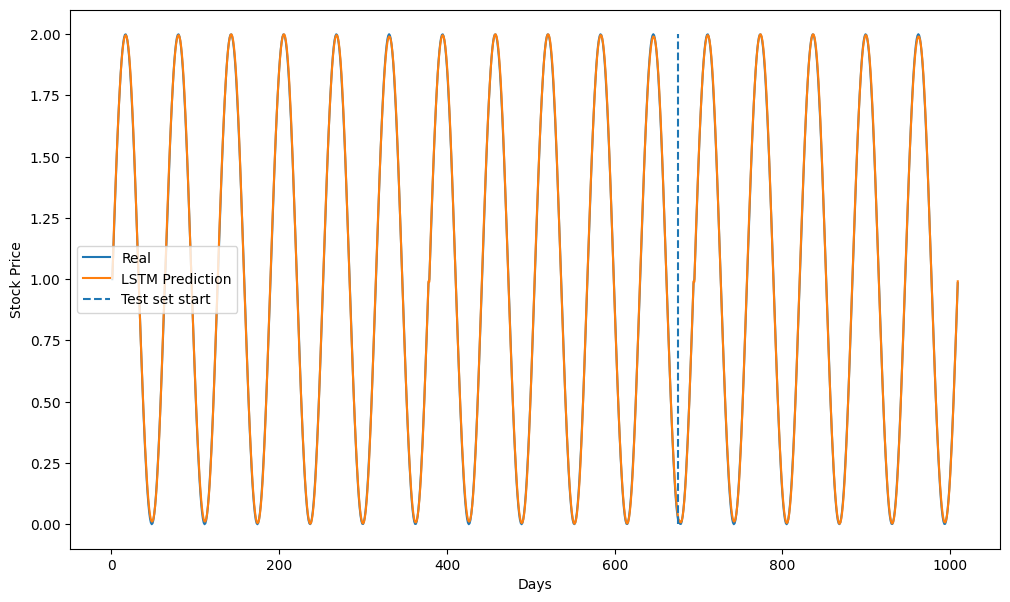

In [49]:
plt.figure(figsize=(12, 7))
plt.plot(range(1,1009), df_out["sin(x)+1"], label = "Real")
plt.plot(range(1,1009), df_out["Model forecast"], label = "LSTM Prediction")
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.vlines(size, ymin = 0, ymax = 2, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()

## Quantum prediction

In [50]:
from utils import QShallowRegressionLSTM

In [51]:
learning_rate = 0.05
num_hidden_units = 16

Qmodel = QShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units, n_qubits=4)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adagrad(Qmodel.parameters(), lr=learning_rate)

weight_shapes = (n_qlayers, n_vrotations, n_qubits) = (1, 3, 4)


In [52]:
quantum_loss_train = []
quantum_acc_train = []
quantum_loss_test = []
quantum_acc_test = []
print("Untrained test\n--------")
start = time.time()
test_loss, test_accuracy = test_model(test_loader, Qmodel, loss_function)
end = time.time()
print("Execution time", end - start)
quantum_loss_test.append(test_loss)

for ix_epoch in range(0, 15):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_loss, train_accuracy = train_model(train_loader, Qmodel, loss_function, optimizer=optimizer)
    test_loss, test_accuracy = test_model(test_loader, Qmodel, loss_function)
    end = time.time()
    print("Execution time", end - start)
    quantum_loss_train.append(train_loss)
    quantum_acc_train.append(train_accuracy)
    quantum_loss_test.append(test_loss)
    quantum_acc_test.append(test_accuracy)

Untrained test
--------
Test loss: 1.0749891370236824
Test accuracy: 0.930241871787196
Execution time 52.87962508201599
Epoch 0.0
---------


C:\Users\Usuario\AppData\Local\Temp\ipykernel_13104\3053466712.py:12: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  for ix_epoch in range(0, 15):


Train loss: 0.05953219839343388
Train accuracy: 16.797604443074803
Test loss: 0.0016214011226448374
Test accuracy: 616.7124931550437
Execution time 230.91537714004517
Epoch 1.0
---------
Train loss: 0.0010445835164207763
Train accuracy: 957.2277003337164
Test loss: 0.0006832225712716738
Test accuracy: 1463.4376823510815
Execution time 234.30408906936646
Epoch 2.0
---------
Train loss: 0.0007468898000222185
Train accuracy: 1338.7063651608844
Test loss: 0.0005921667757673316
Test accuracy: 1688.4283247264977
Execution time 230.9413456916809
Epoch 3.0
---------
Train loss: 0.0006219163665454979
Train accuracy: 1607.6747394183787
Test loss: 0.000673260690787087
Test accuracy: 1485.0881758944176
Execution time 229.9586751461029
Epoch 4.0
---------
Train loss: 0.0005505205188728567
Train accuracy: 1816.132827826762
Test loss: 0.0004105813220498142
Test accuracy: 2434.978038467266
Execution time 229.4354796409607
Epoch 5.0
---------
Train loss: 0.00047346655560110193
Train accuracy: 2111.6356

In [56]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col_Q = "Model forecast"
df_train[ystar_col_Q] = predict(train_eval_loader, Qmodel).numpy()
df_test[ystar_col_Q] = predict(test_loader, Qmodel).numpy()

df_out_Q = pd.concat((df_train, df_test))[[target, ystar_col_Q]]

for c in df_out_Q.columns:
    df_out_Q[c] = df_out_Q[c] * target_stdev + target_mean

print(df_out_Q)

      sin(x)+1  Model forecast
0     1.000000        1.003776
1     1.099833        1.123993
2     1.198669        1.215593
3     1.295520        1.313503
4     1.389418        1.407508
...        ...             ...
1003  0.595962        0.606534
1004  0.689303        0.701670
1005  0.785747        0.798683
1006  0.884333        0.897441
1007  0.984074        0.997922

[1009 rows x 2 columns]


C:\Users\Usuario\AppData\Local\Temp\ipykernel_13104\2494158045.py:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(1,1009), df_out_Q["sin(x)+1"], label = "Real")
C:\Users\Usuario\AppData\Local\Temp\ipykernel_13104\2494158045.py:3: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(1,1009), df_out_Q["Model forecast"], label = "QLSTM Prediction")


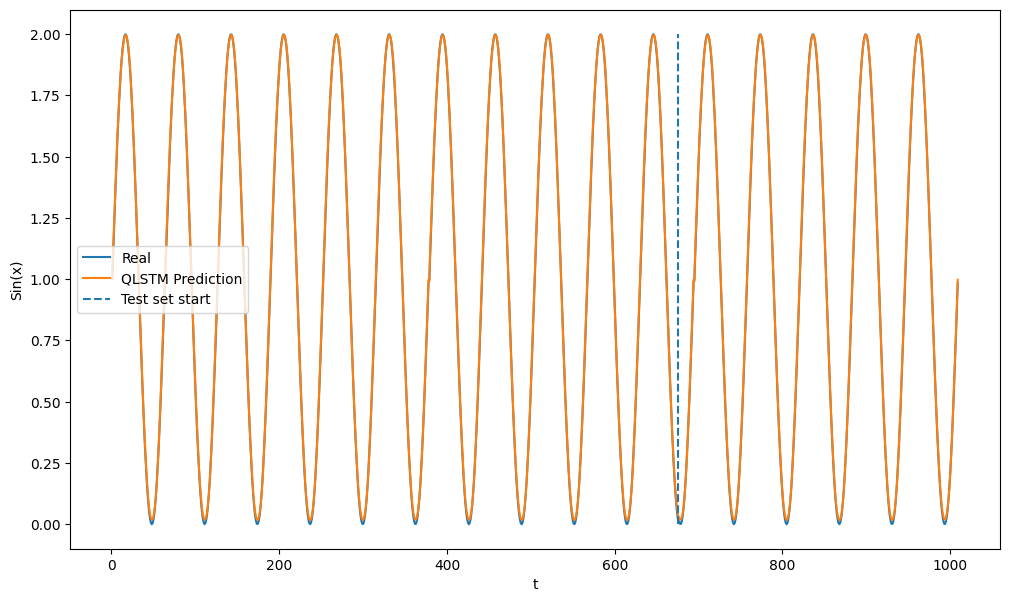

In [57]:
plt.figure(figsize=(12, 7))
plt.plot(range(1,1009), df_out_Q["sin(x)+1"], label = "Real")
plt.plot(range(1,1009), df_out_Q["Model forecast"], label = "QLSTM Prediction")
plt.ylabel('Sin(x)')
plt.xlabel('t')
plt.vlines(size, ymin = 0, ymax = 2, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_13104\1664870560.py:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(0, 16), quantum_loss_test)


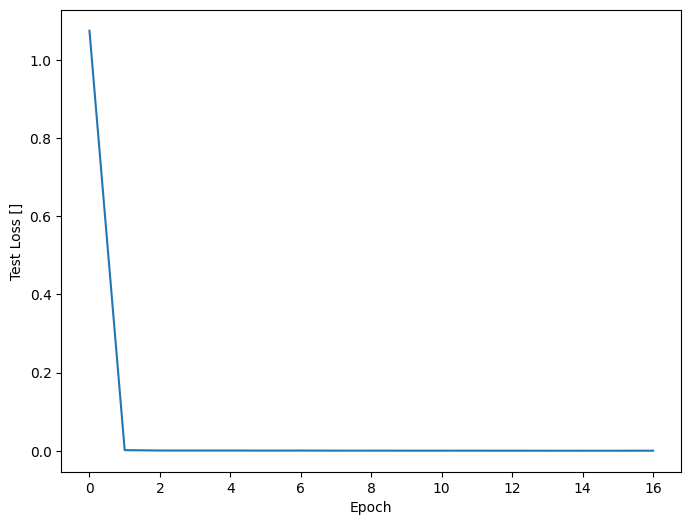

In [62]:
plt.figure(figsize=(8, 6))
plt.plot(range(0, 16), quantum_loss_test)
plt.ylabel('Test Loss')
plt.xlabel('Epoch')
plt.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_13104\1658921019.py:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(0, 15), quantum_acc_test)


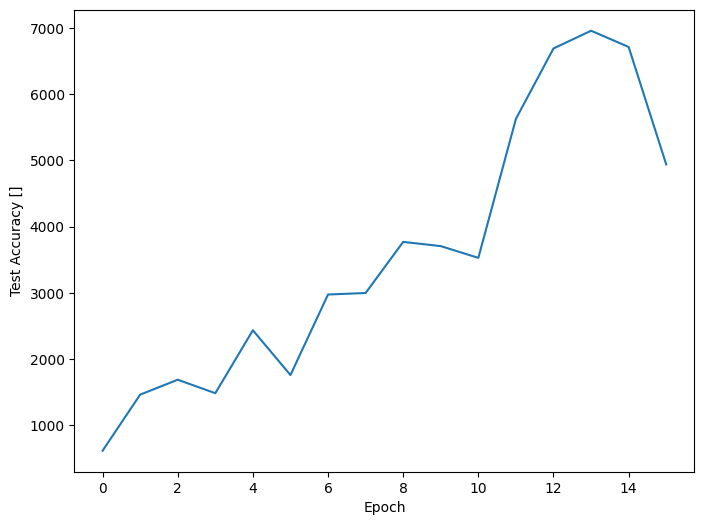

In [66]:
plt.figure(figsize=(8, 6))
plt.plot(range(0, 15), quantum_acc_test)
plt.ylabel('Test Accuracy')
plt.xlabel('Epoch')
plt.show()

# Other finance data forecasting

In [3]:
import helper
import pennylane
import pandas as pd
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import torch

from torch import *
from torch import nn
from torch.utils.data import DataLoader
from IPython.display import Image

df = pd.read_csv('data_Luis.csv')
df

,Fecha,Apertura,Maximo,Minimo,Cierre,Aj_ Cierre,Volumen,Variacion,Yahoo = Investing
0,04/01/2010,32120.74023,32758.52930,32120.74023,32758.52930,32758.52930,136257800,1.99%,si
1,05/01/2010,32729.30078,33073.71094,32628.24023,32732.75977,32732.75977,165541900,-0.08%,si
2,06/01/2010,32730.41992,32922.12109,32639.43945,32830.16016,32830.16016,126000100,0.30%,si
3,07/01/2010,32830.21875,33069.78125,32670.98047,33064.57031,33064.57031,123563200,0.71%,si
4,08/01/2010,33067.57031,33080.05078,32779.66016,32892.03906,32892.03906,109516900,-0.52%,si
...,...,...,...,...,...,...,...,...,...
3266,26/12/2022,50530.62891,50712.39063,50211.37109,50273.89063,50273.89063,11411000,-0.60%,si
3267,27/12/2022,50305.69922,50838.64844,50277.12109,50440.01953,50440.01953,54768700,0.33%,si
3268,28/12/2022,50432.78125,50491.08984,49605.37891,49648.21094,49648.21094,73263800,-1.57%,si
3269,29/12/2022,49708.67188,50209.78906,49461.51953,49517.85938,49517.85938,63993800,-0.26%,si


In [4]:
target = "Cierre"

In [5]:
df = df.drop(['Fecha' ,'Yahoo = Investing','Variacion'], axis=1)
df



,Apertura,Maximo,Minimo,Cierre,Aj_ Cierre,Volumen
0,32120.74023,32758.52930,32120.74023,32758.52930,32758.52930,136257800
1,32729.30078,33073.71094,32628.24023,32732.75977,32732.75977,165541900
2,32730.41992,32922.12109,32639.43945,32830.16016,32830.16016,126000100
3,32830.21875,33069.78125,32670.98047,33064.57031,33064.57031,123563200
4,33067.57031,33080.05078,32779.66016,32892.03906,32892.03906,109516900
...,...,...,...,...,...,...
3266,50530.62891,50712.39063,50211.37109,50273.89063,50273.89063,11411000
3267,50305.69922,50838.64844,50277.12109,50440.01953,50440.01953,54768700
3268,50432.78125,50491.08984,49605.37891,49648.21094,49648.21094,73263800
3269,49708.67188,50209.78906,49461.51953,49517.85938,49517.85938,63993800


In [6]:
features = list(df.columns.difference(['Cierre','Yahoo = Investing','Variacion']))
features

['Aj_ Cierre', 'Apertura', 'Maximo', 'Minimo', 'Volumen']

In [7]:
training_percentage = 0.67
size = int(len(df) * training_percentage)

df_train = df.loc[:size].copy()
df_test = df.loc[size:].copy()

In [8]:
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

## Classic prediction

In [9]:
from utils import SequenceDataset

In [10]:
torch.manual_seed(101) #Sets the seed for generating random numbers.

batch_size = 1
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 3, 5])
Target shape: torch.Size([1])


In [11]:
import matplotlib.pyplot as plt
import numpy as np

def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    accuracy = 1.0 / (avg_loss + 1e-7)

    print(f"Train loss: {avg_loss}")
    print(f"Train accuracy: {accuracy}")
    return avg_loss, accuracy


def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    accuracy = 1.0 / (avg_loss + 1e-7)
    print(f"Test loss: {avg_loss}")
    print(f"Test accuracy: {accuracy}")
    return avg_loss, accuracy

In [12]:
from utils import ShallowRegressionLSTM

In [13]:
learning_rate = 0.0001
num_hidden_units = 16

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
classical_loss_train = []
classical_acc_train = []
classical_loss_test = []
classical_acc_test = []
print("Untrained test\n--------")
test_loss, test_accuracy = test_model(test_loader, model, loss_function)
print()
classical_loss_test.append(test_loss)
classical_acc_test.append(test_accuracy)

for ix_epoch in range(0,12):
  print(f"Epoch {ix_epoch}\n---------")
  train_loss, train_accuracy = train_model(train_loader, model, loss_function, optimizer=optimizer)
  test_loss, test_accuracy = test_model(test_loader, model, loss_function)
  classical_loss_train.append(train_loss)
  classical_acc_train.append(train_accuracy)
  classical_loss_test.append(test_loss)
  classical_acc_test.append(test_accuracy)

Untrained test
--------


Test loss: 1.1550659011417632
Test accuracy: 0.8657513934368398

Epoch 0.0
---------


C:\TEMP\ipykernel_14032\2646794488.py:11: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  for ix_epoch in range(0,12):


Train loss: 0.2860037911095412
Train accuracy: 3.496455926248199
Test loss: 0.15040958386102476
Test accuracy: 6.648508090236915
Epoch 1.0
---------
Train loss: 0.03038746667138429
Train accuracy: 32.90819600049422
Test loss: 0.08650121573861236
Test accuracy: 11.5605177963047
Epoch 2.0
---------
Train loss: 0.013256130753121046
Train accuracy: 75.43622456666728
Test loss: 0.047191330664886365
Test accuracy: 21.19028785334258
Epoch 3.0
---------
Train loss: 0.006917871871224321
Train accuracy: 144.55103585482246
Test loss: 0.027919644148504282
Test accuracy: 35.8169471282054
Epoch 4.0
---------
Train loss: 0.004505973426088651
Train accuracy: 221.92270419082297
Test loss: 0.018860721006667046
Test accuracy: 53.01996130743797
Epoch 5.0
---------
Train loss: 0.0036470583146319684
Train accuracy: 274.1860686409247
Test loss: 0.01641129838165013
Test accuracy: 60.93325972259119
Epoch 6.0
---------
Train loss: 0.003212110175824353
Train accuracy: 311.31213253920066
Test loss: 0.013670164400

In [15]:
def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output

In [16]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

           Cierre  Model forecast
0     32758.52930    32422.945312
1     32732.75977    32550.378906
2     32830.16016    32639.253906
3     33064.57031    32765.390625
4     32892.03906    32829.089844
...           ...             ...
3266  50273.89063    50100.734375
3267  50440.01953    50239.867188
3268  49648.21094    49966.125000
3269  49517.85938    49675.652344
3270  48463.85938    49116.605469

[3272 rows x 2 columns]


C:\TEMP\ipykernel_14032\949093865.py:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(1,3272), df_out["Cierre"], label = "Real")
C:\TEMP\ipykernel_14032\949093865.py:3: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(1,3272), df_out["Model forecast"], label = "LSTM Prediction")


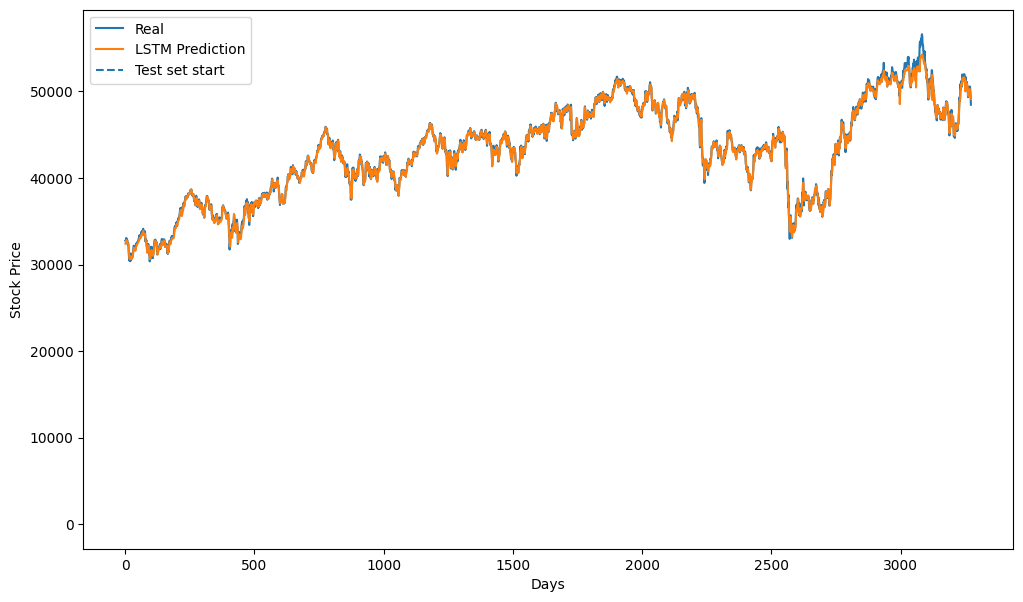

In [17]:
plt.figure(figsize=(12, 7))
plt.plot(range(1,3272), df_out["Cierre"], label = "Real")
plt.plot(range(1,3272), df_out["Model forecast"], label = "LSTM Prediction")
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.vlines(size, ymin = 0, ymax = 60000, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()

## Quantum prediction

In [18]:
from utils import QShallowRegressionLSTM

In [19]:
learning_rate = 0.05
num_hidden_units = 16

Qmodel = QShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units, n_qubits=4)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adagrad(Qmodel.parameters(), lr=learning_rate)

weight_shapes = (n_qlayers, n_vrotations, n_qubits) = (1, 3, 4)


In [20]:
quantum_loss_train = []
quantum_acc_train = []
quantum_loss_test = []
quantum_acc_test = []
print("Untrained test\n--------")
start = time.time()
test_loss, test_accuracy = test_model(test_loader, Qmodel, loss_function)
end = time.time()
print("Execution time", end - start)
quantum_loss_test.append(test_loss)

for ix_epoch in range(0, 15):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_loss, train_accuracy = train_model(train_loader, Qmodel, loss_function, optimizer=optimizer)
    test_loss, test_accuracy = test_model(test_loader, Qmodel, loss_function)
    end = time.time()
    print("Execution time", end - start)
    quantum_loss_train.append(train_loss)
    quantum_acc_train.append(train_accuracy)
    quantum_loss_test.append(test_loss)
    quantum_acc_test.append(test_accuracy)

Untrained test
--------
Test loss: 1.586029918170134
Test accuracy: 0.6305050904104197
Execution time 115.04254984855652
Epoch 0.0
---------


C:\TEMP\ipykernel_14032\3053466712.py:12: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  for ix_epoch in range(0, 15):


Train loss: 0.03250051893560412
Train accuracy: 30.76864480585351
Test loss: 0.12565398631842054
Test accuracy: 7.958356383778049
Execution time 510.0876762866974
Epoch 1.0
---------
Train loss: 0.001155922816589644
Train accuracy: 865.0348294595748
Test loss: 0.07850877524081101
Test accuracy: 12.737413406225608
Execution time 503.1585605144501
Epoch 2.0
---------
Train loss: 0.0008033816074748194
Train accuracy: 1244.5835607149718
Test loss: 0.06153677136967142
Test accuracy: 16.25041991479684
Execution time 504.08856534957886
Epoch 3.0
---------
Train loss: 0.0006136821104545239
Train accuracy: 1629.2426627740426
Test loss: 0.045356504260120174
Test accuracy: 22.0475058993614
Execution time 601.038055896759
Epoch 4.0
---------
Train loss: 0.0005314816947856406
Train accuracy: 1881.1783961132228
Test loss: 0.03970492954710376
Test accuracy: 25.185726126048024
Execution time 615.6219913959503
Epoch 5.0
---------
Train loss: 0.0004501688675994487
Train accuracy: 2220.8952738202242
Test

In [21]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col_Q = "Model forecast"
df_train[ystar_col_Q] = predict(train_eval_loader, Qmodel).numpy()
df_test[ystar_col_Q] = predict(test_loader, Qmodel).numpy()

df_out_Q = pd.concat((df_train, df_test))[[target, ystar_col_Q]]

for c in df_out_Q.columns:
    df_out_Q[c] = df_out_Q[c] * target_stdev + target_mean

print(df_out_Q)

           Cierre  Model forecast
0     32758.52930    32560.894531
1     32732.75977    32747.148438
2     32830.16016    32798.367188
3     33064.57031    32973.140625
4     32892.03906    32910.457031
...           ...             ...
3266  50273.89063    50379.136719
3267  50440.01953    50500.492188
3268  49648.21094    49847.625000
3269  49517.85938    49680.328125
3270  48463.85938    48654.542969

[3272 rows x 2 columns]


C:\TEMP\ipykernel_14032\3604983494.py:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(1,3272), df_out_Q["Cierre"], label = "Real")
C:\TEMP\ipykernel_14032\3604983494.py:3: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(1,3272), df_out_Q["Model forecast"], label = "QLSTM Prediction")


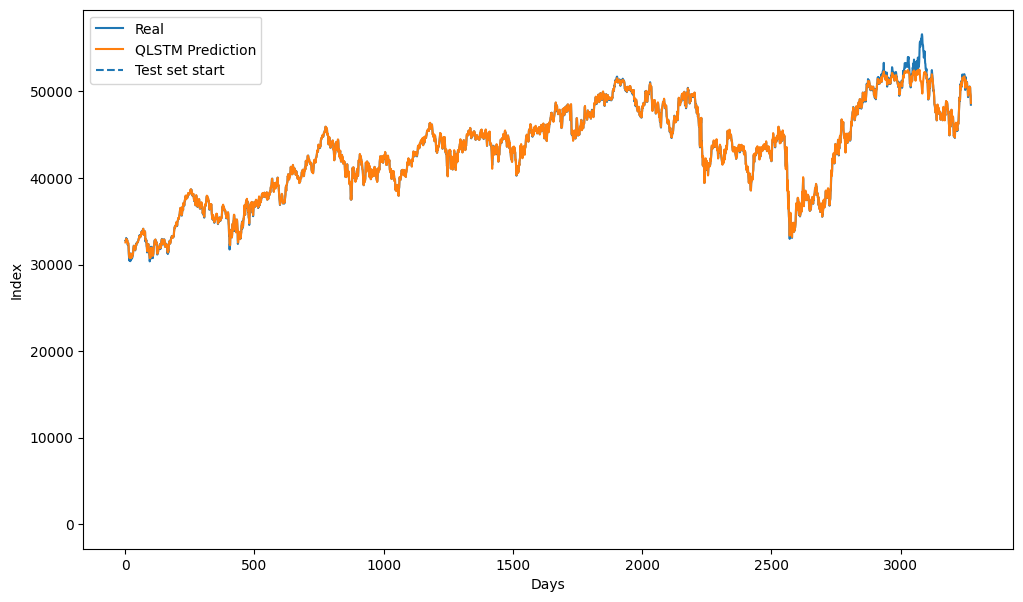

In [22]:
plt.figure(figsize=(12, 7))
plt.plot(range(1,3272), df_out_Q["Cierre"], label = "Real")
plt.plot(range(1,3272), df_out_Q["Model forecast"], label = "QLSTM Prediction")
plt.ylabel('Index')
plt.xlabel('Days')
plt.vlines(size, ymin = 0, ymax = 60000, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()

In [23]:
quantum_loss_test

[1.586029918170134,
 0.12565398631842054,
 0.07850877524081101,
 0.06153677136967142,
 0.045356504260120174,
 0.03970492954710376,
 0.03492235540316443,
 0.028000034744730957,
 0.0244217312970672,
 0.02049675269275719,
 0.02070666599173539,
 0.018820778458660713,
 0.017376508550798135,
 0.01676019033805365,
 0.016789081776923974,
 0.015516751235774229,
 0.01518482428552672]

C:\TEMP\ipykernel_14032\3470302015.py:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(1, 17), quantum_loss_test)


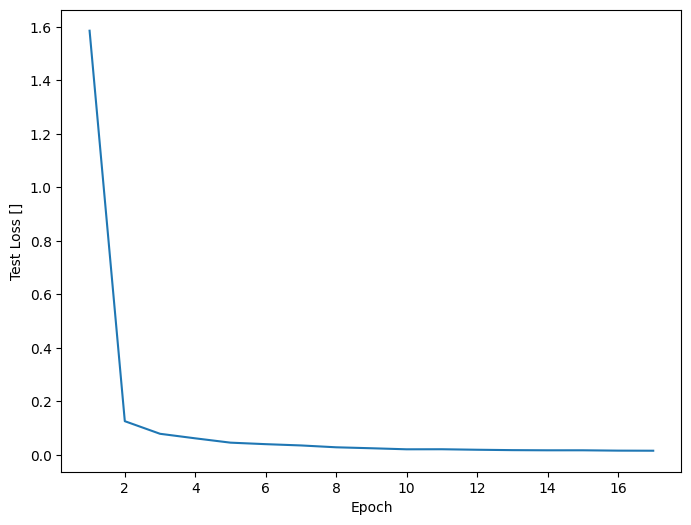

In [25]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 17), quantum_loss_test)
plt.ylabel('Test Loss')
plt.xlabel('Epoch')
plt.show()

C:\TEMP\ipykernel_14032\2555336839.py:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(1, 16), quantum_acc_test)


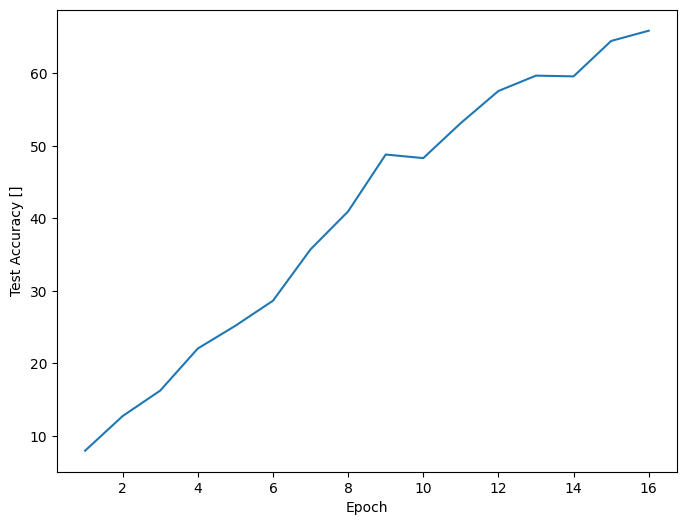

In [28]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 16), quantum_acc_test)
plt.ylabel('Test Accuracy')
plt.xlabel('Epoch')
plt.show()